In [287]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [288]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

In [289]:
# for name in dir():
#     if not name.startswith('_'):
#         del globals()[name]

In [290]:
# ============= Import required packaages ==============
import time

# Import all custom variables and modules
from custom_classes_defs.preprocessing import *
# from custom_classes_defs.Unet_like import *   
from custom_classes_defs.fnet import *

RND_STATE = 247
BATCH_SIZE = 256
keras.utils.set_random_seed(RND_STATE)

INTERACTIVE_SESSION = True

from tensorflow.data import Dataset as tf_data
# -------------------------------------------------------

### Data preparation and model configurations

In [291]:
print("{}\n\t{}\n{}".format('='*55,'Data preparation and model configurations', '-'*55))
# Hand-written alphabet images
start = time.time()
if 'letters' not in dir():
    letters = MNIST_letters(
        './data/az_handwritten_alphabets_in_csv_format/A_Z_Handwritten_Data.csv'
    )
    
# Load data (split ratio = train:val:test = 5:1:4)
(x_train, _), (x_test, _), (x_val, _) = \
    letters.split_data(train_ratio=0.1, val_ratio=1./6)
print("Shape of dataset: {}".format(str(letters.df.shape)))
print("Shape of training data: {}".format(str(x_train.shape)))
print("Shape of validation data: {}".format(str(x_val.shape)))
print("Shape of test data: {}".format(str(x_test.shape))) 

x_test = x_test[:1000]


# Create data generator for respective data samples and labels
        
train_dataset = tf_data.from_tensor_slices(letters.generate_data(x_train)) \
                .batch(BATCH_SIZE)
val_dataset = tf_data.from_tensor_slices(letters.generate_data(x_val)) \
                .batch(BATCH_SIZE)
x_test, y_test = letters.generate_data(x_test)
print("Train Dataset:", train_dataset)
print('...elapsed time: ___{:5.2f} minutes___'.format((time.time()-start) / 60))

	Data preparation and model configurations
-------------------------------------------------------
Shape of dataset: (144013, 784)
Shape of training data: (12000, 28, 28)
Shape of validation data: (2401, 28, 28)
Shape of test data: (129612, 28, 28)
Train Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 28, 28), dtype=tf.int64, name=None))>
...elapsed time: ___ 0.05 minutes___


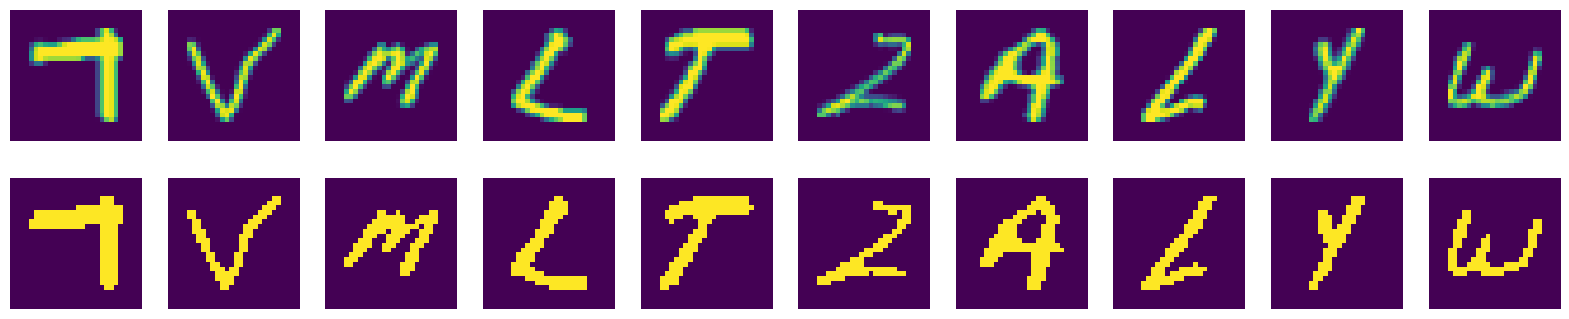

In [292]:
display_sample_images(x_test, y_test, img_shape=(28,28))

In [293]:

# Model configurations
conf = model_config(
    epochs=10,
    batch_size=BATCH_SIZE,
    shuffle=True,
    scaling=1,
    verbose=1,
    save_path='./data',
    augmentation=True,
    threshold=letters.threshold,
    pos_label=letters.pos_label
)


es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

conf.set( validation_data=val_dataset,  callbacks=[es_callback] )
conf.set('compile')
conf.info()

        compile_args:
                     optimizer: adam
                          loss: binary_crossentropy
       training_args:
                        epochs: 10
                    batch_size: 256
                       shuffle: True
                       verbose: 1
               validation_data: <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
                     callbacks: <class 'list'>
          model_arch:
                     img_shape: (28, 28)
                   target_size: (28, 28)
                  channels_dim: (1, 1)
                       scaling: 1
                  augmentation: True
new_training_session: False
           save_path: ./data
           threshold: 0.5
           pos_label: 1


In [294]:
### Interactive step:
if INTERACTIVE_SESSION:
    train = input("New train session? (y/n): ")
    if train[0].lower()=='y':
        conf.new_training_session = True
    else:
        conf.new_training_session = False
    interact = input("Are you sure, you want to run this session interactively? (y/n): ")
    if interact[0].lower()!='y':
        INTERACTIVE_SESSION = False

New train session? (y/n):  y
Are you sure, you want to run this session interactively? (y/n):  y


### Build  model 

In [295]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Build model', '-'*55))
m_obj = FNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
model = m_obj.build_model()
# model.summary()
# keras.utils.plot_model(model, 'm_obj.png',show_shapes=True)
print(f"Total trainable wieghts: {model.count_params():,}")





	Build model
-------------------------------------------------------
inputs padded by 2 to fit model design
Cropping the output by 2 to fit input...
Total trainable wieghts: 8,065,089


### Train and evaluate  model



	Train fnet model
-------------------------------------------------------
Model training...
Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - loss: 2.9152 - val_loss: 2.2925
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - loss: 2.2824 - val_loss: 2.2925
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/step - loss: 2.2824 - val_loss: 2.2925
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - loss: 2.2824 - val_loss: 2.2925
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 176s 4s/step - loss: 2.2824 - val_loss: 2.2925
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 211s 4s/step - loss: 2.2824 - val_loss: 2.2925
training elapsed time: ___16.39 minutes___
...training completed!


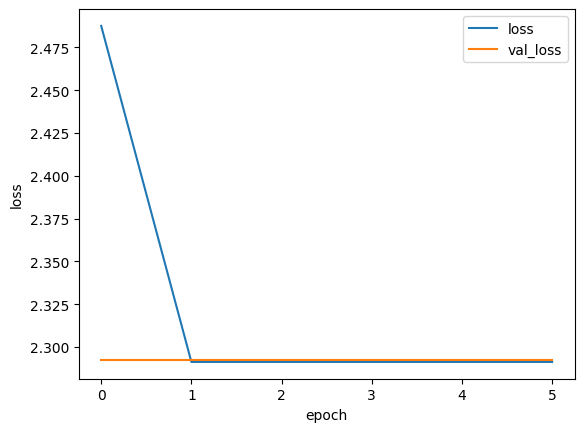

In [296]:

print("\n\n{}\n\t{}\n{}".format('='*55,f'Train {m_obj.Name} model', '-'*55))

conf.execute_training(
    model, 
    data=train_dataset, 
    saveas=m_obj.Name+'_aug', 
    plot_history=INTERACTIVE_SESSION
)




	Evaluate fnet model
-------------------------------------------------------
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 476ms/step
evaluation elapsed time:___ 0.02___minutes
{'Avg-precision': 0.14, 'f1-score(ODS)': 0.0, 'f1-score(OIS)': 0.0}


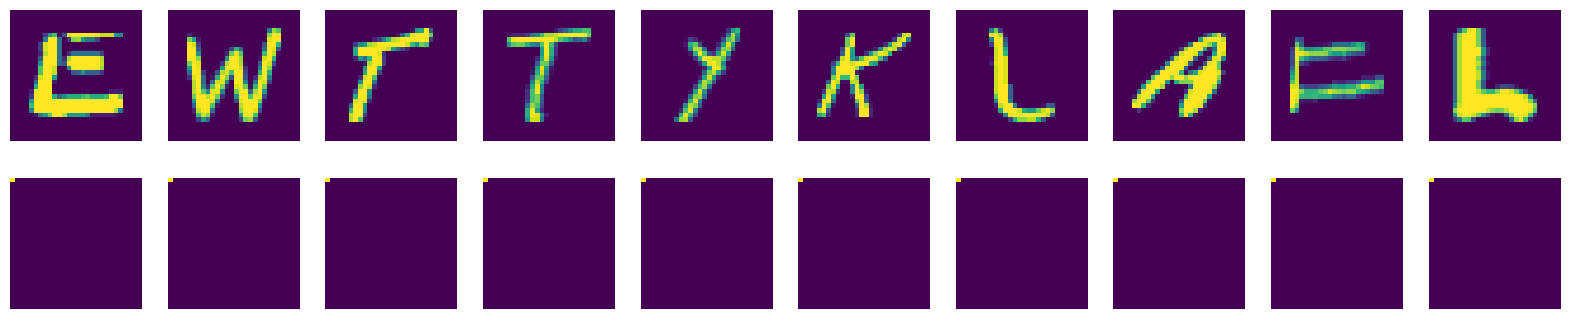

In [297]:


print("\n\n{}\n\t{}\n{}".format('='*55,f'Evaluate {m_obj.Name} model', '-'*55))
decoded_imgs = model.predict(x_test)
scores = m_obj.evaluate_sklearn(y_test, decoded_imgs,report=True)
print(scores)

if INTERACTIVE_SESSION:
    display_sample_images(x_test, decoded_imgs, conf.img_shape)
    